In [1]:
import os
os.environ['MNE_DATASETS_wang2016_PATH'] = 'E:/dataset/'

In [2]:
import matplotlib.pyplot as plt
import mne
import numpy as np
from scipy.stats import ttest_rel
import scipy.io
from mne.channels import make_standard_montage
from mne import create_info
from mne.io import RawArray

In [3]:
path = r"E:\Thesis\HybridSpeller\wang_experiment\sunsun.mat"
raw_mat = scipy.io.loadmat(path)

In [4]:
_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']

In [5]:
srate = 250
montage = make_standard_montage("standard_1020")
montage.rename_channels(
    {ch_name: ch_name.upper() for ch_name in montage.ch_names}
)

ch_names = [ch_name.upper() for ch_name in _CHANNELS]
ch_names = ch_names + ['STIM']
ch_types = ["eeg"] * 9
ch_types[-1] = "stim"

info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=srate)
info

<Info | 7 non-empty values
 bads: []
 ch_names: FZ, C3, CZ, C4, PZ, PO7, OZ, PO8, STIM
 chs: 8 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 9
 projs: []
 sfreq: 250.0 Hz
>

In [6]:
n_channels, n_samples = 9, 1500
data = np.transpose(raw_mat["data"], axes=(2, 3, 0, 1))
print(data.shape)
data = np.reshape(data, newshape=(-1, n_channels, n_samples))
print(data.shape)
data = data - data.mean(axis=2, keepdims=True)
print(data.shape)
data = np.concatenate(list(data), axis=1)
raw = RawArray(data=data, info=info, verbose=False)
raw.set_montage(montage)
# sessions = {"session_0": {"run_0": raw}}

(5, 9, 9, 1500)
(45, 9, 1500)
(45, 9, 1500)


<RawArray | 9 x 67500 (270.0 s), ~4.7 MB, data loaded>

In [7]:
# sessions

In [8]:
# session_name = "session_0"
# run_name = "run_0"
# raw_list = [sessions[session_name][run_name]]

# raw = mne.concatenate_raws(raw_list)

<!-- fname = C:\Users\Sunsun\mne_data\MNE-nakanishi-data\mnakanishi\12JFPM_SSVEP\raw\master\data\s1.mat -->

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


c:\Users\Sunsun\.virtualenvs\HybridSpeller-q8UBACmb\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


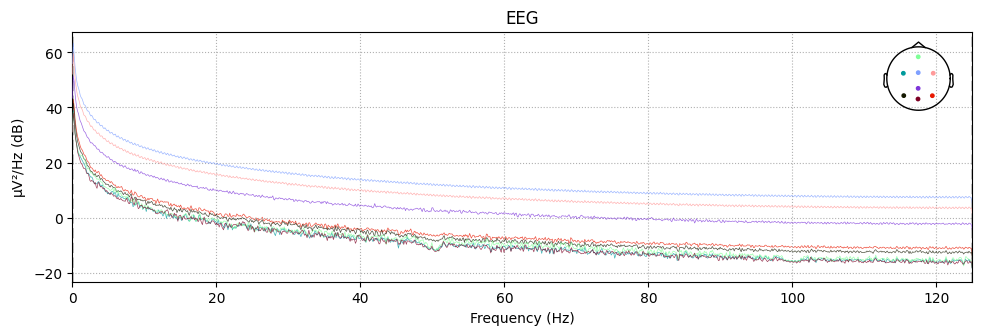

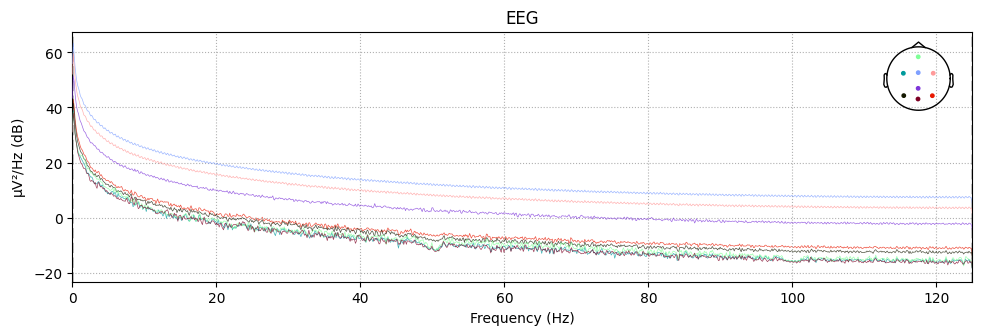

In [9]:
raw.plot_psd()

In [10]:
# Load raw data
# data_path = mne.datasets.ssvep.data_path()
# data_path = moabb.datasets.Nakanishi2015.data_path(subject = 1)

# bids_fname = (data_path)

# raw = mne.io.read_raw_brainvision(bids_fname, preload=True, verbose=False)
raw.info['line_freq'] = 60.

# Set montage
# montage = mne.channels.make_standard_montage('standard_1020')
# raw.set_montage(montage, verbose=False)

# Set common average reference
raw.set_eeg_reference('average', projection=False, verbose=False)

# Apply bandpass filter
raw.filter(l_freq=0.1, h_freq=None, fir_design='firwin', verbose=False)

# Construct epochs
event_id = {
    '8hz': 3,
    '9hz': 6
}
# events, _ = mne.events_from_annotations(raw, verbose=False)
events = mne.find_events(raw, initial_event = True)
tmin, tmax = -1., 5.  # in s
baseline = None
epochs = mne.Epochs(
    raw, events=events,
    event_id=[event_id['8hz'], event_id['9hz']], tmin=tmin,
    tmax=tmax, baseline=baseline, verbose=False)

40 events found
Event IDs: [1 2 3 4 5 6 7 8]


In [11]:
tmin = 1.
tmax = 5.
fmin = 1.
fmax = 90.
sfreq = epochs.info['sfreq']

spectrum = epochs.compute_psd(
    'welch',
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0, n_per_seg=None,
    tmin=tmin, tmax=tmax,
    fmin=fmin, fmax=fmax,
    window='boxcar',
    verbose=False)
psds, freqs = spectrum.get_data(return_freqs=True)

In [12]:
def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """Compute SNR spectrum from PSD spectrum using convolution.

    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring
    # frequencies
    averaging_kernel = np.concatenate((
        np.ones(noise_n_neighbor_freqs),
        np.zeros(2 * noise_skip_neighbor_freqs + 1),
        np.ones(noise_n_neighbor_freqs)))
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the
    # averaging kernel.
    mean_noise = np.apply_along_axis(
        lambda psd_: np.convolve(psd_, averaging_kernel, mode='valid'),
        axis=-1, arr=psd
    )

    # The mean is not defined on the edges so we will pad it with nas. The
    # padding needs to be done for the last dimension only so we set it to
    # (0, 0) for the other ones.
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(
        mean_noise, pad_width=pad_width, constant_values=np.nan
    )

    return psd / mean_noise

In [13]:
snrs = snr_spectrum(psds, noise_n_neighbor_freqs=3,
                    noise_skip_neighbor_freqs=1)

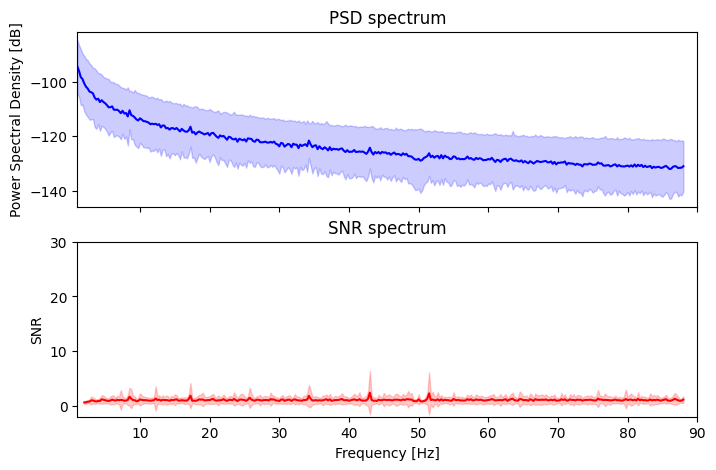

In [14]:
fig, axes = plt.subplots(2, 1, sharex='all', sharey='none', figsize=(8, 5))
freq_range = range(np.where(np.floor(freqs) == 1.)[0][0],
                   np.where(np.ceil(freqs) == fmax - 1)[0][0])

psds_plot = 10 * np.log10(psds)
psds_mean = psds_plot.mean(axis=(0, 1))[freq_range]
psds_std = psds_plot.std(axis=(0, 1))[freq_range]
axes[0].plot(freqs[freq_range], psds_mean, color='b')
axes[0].fill_between(
    freqs[freq_range], psds_mean - psds_std, psds_mean + psds_std,
    color='b', alpha=.2)
axes[0].set(title="PSD spectrum", ylabel='Power Spectral Density [dB]')

# SNR spectrum
snr_mean = snrs.mean(axis=(0, 1))[freq_range]
snr_std = snrs.std(axis=(0, 1))[freq_range]

axes[1].plot(freqs[freq_range], snr_mean, color='r')
axes[1].fill_between(
    freqs[freq_range], snr_mean - snr_std, snr_mean + snr_std,
    color='r', alpha=.2)
axes[1].set(
    title="SNR spectrum", xlabel='Frequency [Hz]',
    ylabel='SNR', ylim=[-2, 30], xlim=[fmin, fmax])
fig

In [15]:
# Define different ROIs
roi_vis = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']  # visual roi

# Find corresponding indices using mne.pick_types()
picks_roi_vis = mne.pick_types(epochs.info, eeg=True, stim=False,
                               exclude='bads', selection=roi_vis)

i_trial_8hz = np.where(epochs.events[:, 2] == event_id['8hz'])[0]
i_trial_9hz = np.where(epochs.events[:, 2] == event_id['9hz'])[0]


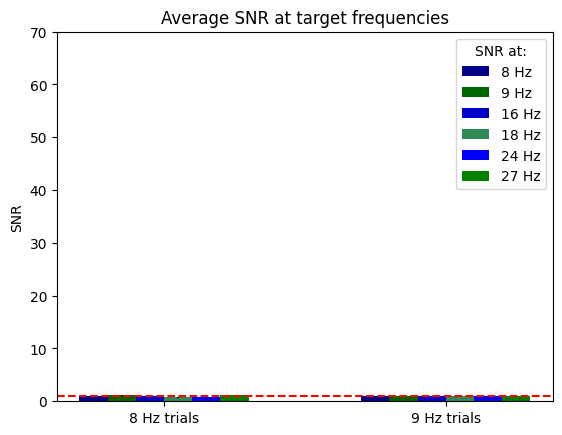

In [16]:
snrs_roi = snrs[:, picks_roi_vis, :].mean(axis=1)

freq_plot = [8, 9, 16, 18, 24, 27]
color_plot = [
    'darkblue', 'darkgreen', 'mediumblue',  'seagreen', 'blue', 'green'
]
xpos_plot = [ -5. / 12, -3. / 12,  -1. / 12, 1. / 12,  3. / 12,  5. / 12]
fig, ax = plt.subplots()
labels = ['8 Hz trials', '9 Hz trials']
x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars
res = dict()

# loop to plot SNRs at stimulation frequencies and harmonics
for i, f in enumerate(freq_plot):
    # extract snrs
    stim_8hz_tmp = \
        snrs_roi[i_trial_8hz, np.argmin(abs(freqs - f))]
    stim_9hz_tmp = \
        snrs_roi[i_trial_9hz, np.argmin(abs(freqs - f))]
    SNR_tmp = [stim_8hz_tmp.mean(), stim_9hz_tmp.mean()]
    # plot (with std)
    ax.bar(
        x + width * xpos_plot[i], SNR_tmp, width / len(freq_plot),
        yerr=np.std(SNR_tmp),
        label='%i Hz SNR' % f, color=color_plot[i])
    # store results for statistical comparison
    res['stim_6hz_snrs_%ihz' % f] = stim_8hz_tmp
    res['stim_9hz_snrs_%ihz' % f] = stim_9hz_tmp

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('SNR')
ax.set_title('Average SNR at target frequencies')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(['%i Hz' % f for f in freq_plot], title='SNR at:')
ax.set_ylim([0, 70])
ax.axhline(1, ls='--', c='r')
# fig.show()
fig